In [3]:
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cartopy.crs as ccrs

DATADIR = './data/cmip6_agg/'

In [20]:


def geog_agg(fn):
    ds = xr.open_dataset(f'{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    try:
        da = da.reset_coords(names='height', drop=True)
    except Exeption as e:
        pass
    # weights = np.cos(np.deg2rad(da.lat))
    # weights.name = "weights"
    # da_weighted = da.weighted(weights)
    # da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

# for filename, model_name in zip(glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'), data_into_list):
#     # print(filename)
#     data = xr.open_dataset(filename)
#     data = data.rename({'tas': model_name})
#     data = data.convert_calendar("noleap", align_on='date')
#     data = data.resample(time='1M').first()
#     try:
#         data = data.drop_vars('height')
#     except ValueError:
#         print('column has no height var')
#     # try:
#     #     data.indexes['time'].to_datetimeindex()
#     # except AttributeError:
#     #     pass
#     data_l.append(data)

# big_df = xr.merge(data_l)

In [21]:
for filename in glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'):
    try:
        geog_agg(filename)
    except Exception as e: 
        print(f'{filename} failed {e}')

data\tas_scenario_245\tas_mon_mod_ssp245_192_000.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_ACCESS-CM2_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_001.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_ACCESS-ESM1-5_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_002.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_AWI-CM-1-1-MR_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_003.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_BCC-CSM2-MR_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_004.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6

In [5]:
data_ds = xr.open_mfdataset(f'cmip6_agg*.nc', coords='minimal', compat='override')
data_ds.load()

<xarray.Dataset>
Dimensions:     (year: 251, model: 36, experiment: 1)
Coordinates:
    height      float64 2.0
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical'
Data variables:
    tas         (experiment, model, year) float32 13.7 13.71 ... 17.6 17.62

In [6]:
# many_times = np.array([
#     "1850-01-16",
#     "1900-01-16",
#     "1950-01-16",
#     "2000-01-16",
#     "2050-01-16",
#     "2100-01-16",
# ], dtype=np.datetime64)
many_times = [1850, 1900, 1950, 2000, 2050, 2100]


temp = data_ds['tas'].sel(year=many_times, method='nearest')
data_50 = temp.quantile(0.5, dim='model')
# display(data_50)
map_proj = ccrs.PlateCarree(central_longitude=0)

p = data_50.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='year', col_wrap=3,  # multiplot settings
             aspect=data_ds.dims['lon'] / data_ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj},
             cmap='jet')

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_ylabel('Longtitude')
    ax.set_xlabel('Latitude')
    # ax.set_extent([288, 336, -44, -12])
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    # ax.set_aspect('equal', 'box-forced')

plt.show()

KeyError: 'lon'

In [7]:
data = data_ds['tas']
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

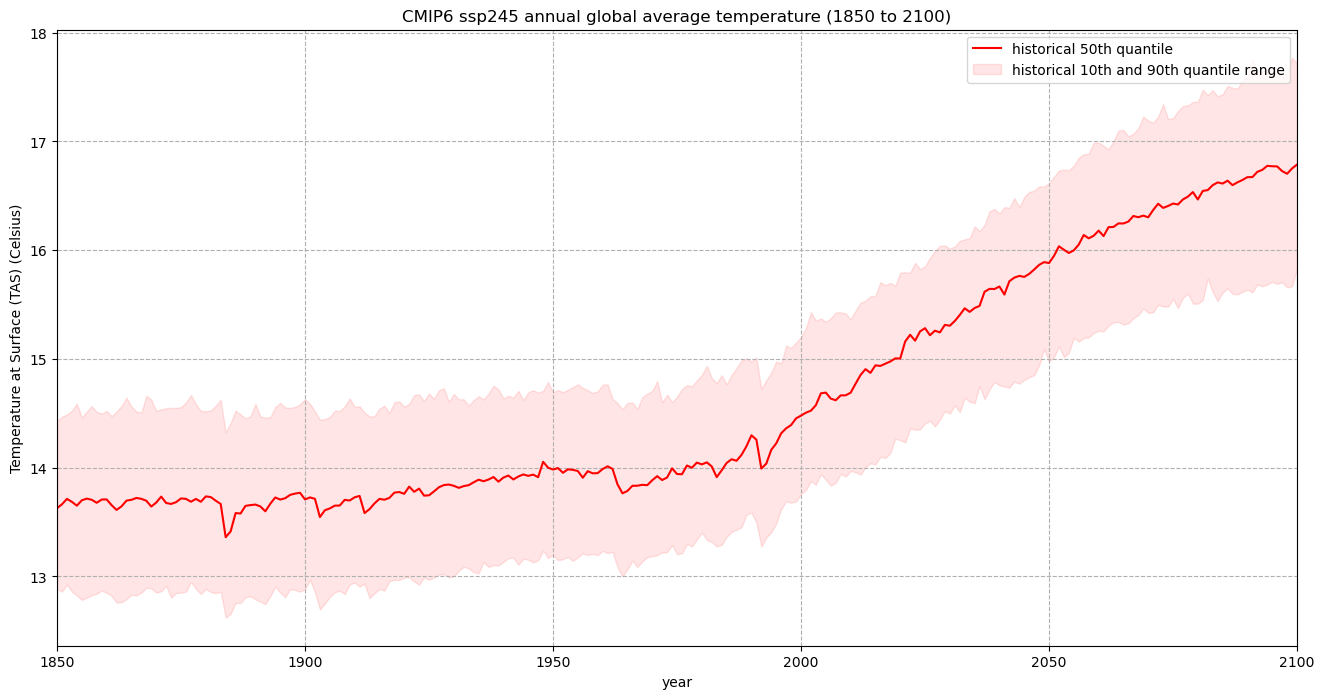

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['red']
experiments = ['ssp245']

for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

# fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

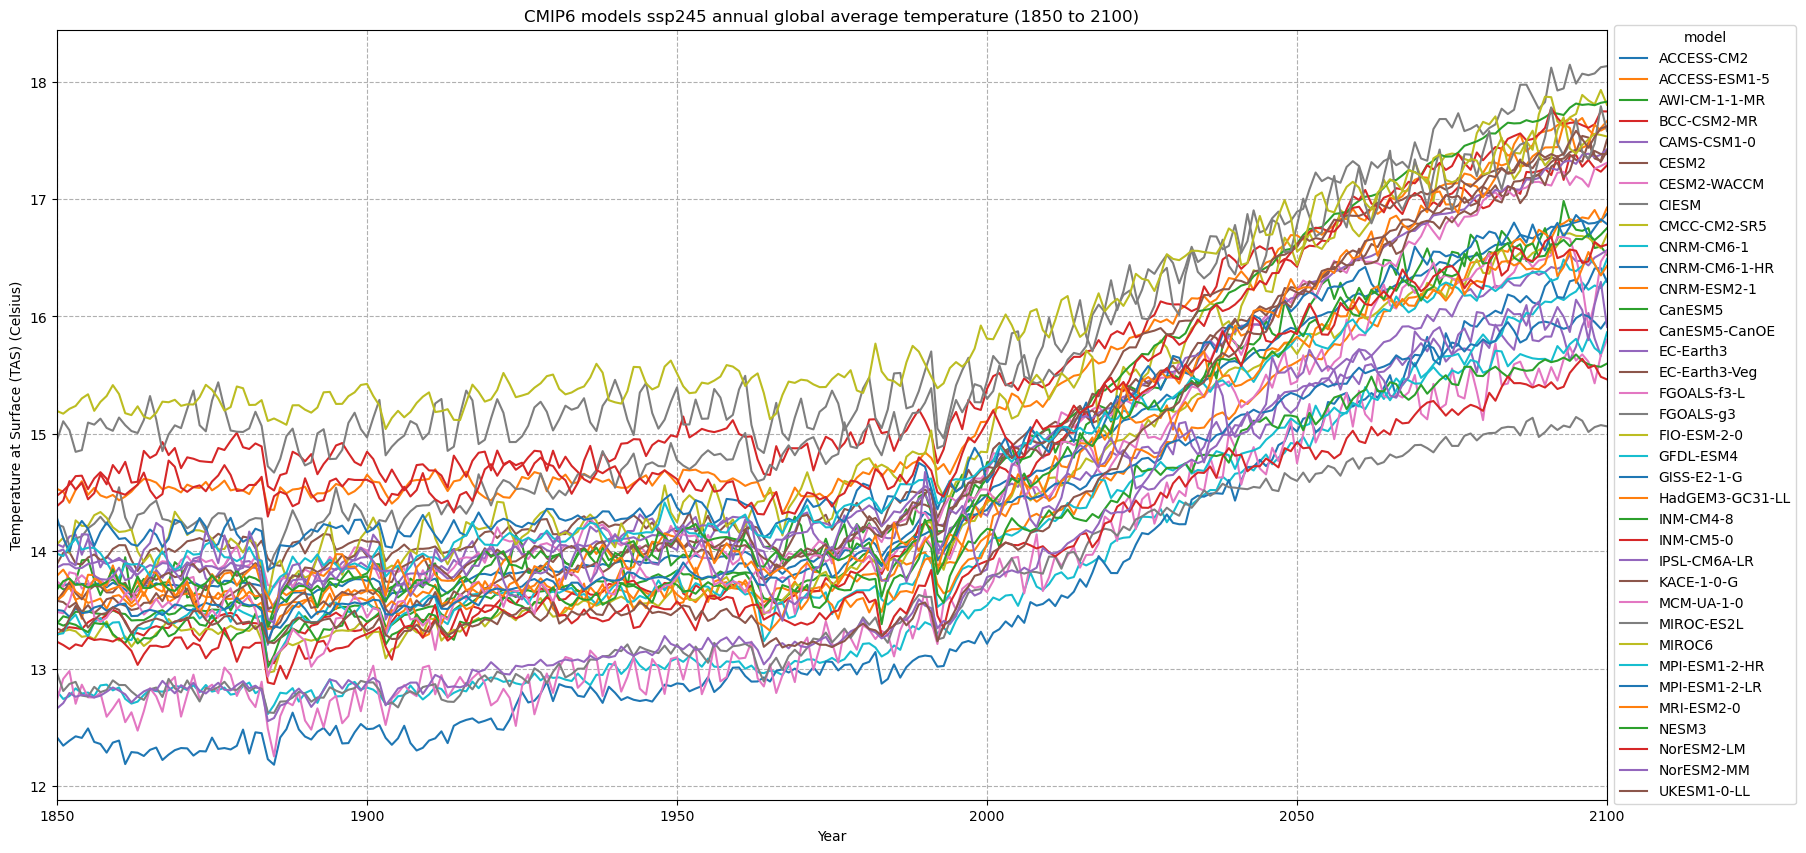

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
data.plot(x='year', hue='model', add_legend=True)
ax.set_xlim(1850,2100)
ax.set_title('CMIP6 models ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('Year')
sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='right', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper left')
ax.grid(linestyle='--')
plt.show()

In [8]:
tmp = data_ds.to_dataframe().reset_index()
tmp

,year,model,experiment,height,tas
0,1850,ACCESS-CM2,historical,2.0,13.703918
1,1850,ACCESS-ESM1-5,historical,2.0,14.530945
2,1850,AWI-CM-1-1-MR,historical,2.0,13.717590
3,1850,BCC-CSM2-MR,historical,2.0,14.384521
4,1850,CAMS-CSM1-0,historical,2.0,14.060303
...,...,...,...,...,...
9031,2100,MRI-ESM2-0,historical,2.0,16.431366
9032,2100,NESM3,historical,2.0,16.753021
9033,2100,NorESM2-LM,historical,2.0,16.612885
9034,2100,NorESM2-MM,historical,2.0,15.910614


In [9]:
tmp['tas'].isna().sum()

1

In [10]:
pivot_df = tmp.pivot(index=['year', 'lat', 'lon'], columns='model', values='tas').reset_index()

KeyError: 'lat'

In [17]:
pivot_df.isna().sum()

model
year                   0
lat                    0
lon                    0
ACCESS-CM2             0
ACCESS-ESM1-5          0
AWI-CM-1-1-MR          0
BCC-CSM2-MR            0
CAMS-CSM1-0        27648
CESM2                  0
CESM2-WACCM            0
CIESM                  0
CMCC-CM2-SR5           0
CNRM-CM6-1             0
CNRM-CM6-1-HR          0
CNRM-ESM2-1            0
CanESM5                0
CanESM5-CanOE          0
EC-Earth3              0
EC-Earth3-Veg          0
FGOALS-f3-L            0
FGOALS-g3              0
FIO-ESM-2-0            0
GFDL-ESM4              0
GISS-E2-1-G            0
HadGEM3-GC31-LL        0
INM-CM4-8              0
INM-CM5-0              0
IPSL-CM6A-LR           0
KACE-1-0-G             0
MCM-UA-1-0             0
MIROC-ES2L             0
MIROC6                 0
MPI-ESM1-2-HR          0
MPI-ESM1-2-LR          0
MRI-ESM2-0             0
NESM3                  0
NorESM2-LM             0
NorESM2-MM             0
UKESM1-0-LL            0
dtype: int64

In [18]:
pivot_df.to_csv('cmip6_yearly.csv')

In [13]:
corr_df = pivot_df.drop(columns = ['year', 'lat', 'lon'])
corr_df

model,ACCESS-CM2,ACCESS-ESM1-5,AWI-CM-1-1-MR,BCC-CSM2-MR,CAMS-CSM1-0,CESM2,CESM2-WACCM,CIESM,CMCC-CM2-SR5,CNRM-CM6-1,...,MCM-UA-1-0,MIROC-ES2L,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,UKESM1-0-LL
0,-46.530746,-46.736160,-47.664902,-45.871475,-40.815903,-48.080521,-48.697372,-47.992569,-47.246490,-49.972214,...,-41.478546,-35.017349,-41.975998,-48.748642,-48.879730,-47.987274,-49.727859,-45.735016,-47.065659,-46.902298
1,-46.555344,-46.753998,-47.644333,-45.911850,-40.825897,-48.149567,-48.764435,-48.001572,-47.332504,-49.972214,...,-41.479218,-35.017609,-42.014923,-48.722015,-48.893478,-47.994644,-49.752701,-45.869400,-47.136444,-46.894882
2,-46.614792,-46.771759,-47.607346,-45.987228,-40.839981,-48.248550,-48.861115,-48.010468,-47.183182,-49.972214,...,-41.760040,-35.262497,-42.054245,-48.672409,-48.893509,-48.013260,-49.752716,-45.940582,-47.237167,-46.881516
3,-46.637253,-46.789536,-47.572479,-46.019073,-40.844711,-48.301620,-48.912277,-48.024216,-47.300156,-49.972214,...,-41.760712,-35.262787,-42.093796,-48.627914,-48.904922,-48.024689,-49.764969,-45.974350,-47.292099,-46.864853
4,-46.684799,-46.807480,-47.533798,-46.096664,-40.855362,-48.345230,-48.954742,-48.039337,-47.138474,-49.914810,...,-41.761383,-35.510727,-42.173294,-48.586288,-48.907974,-48.058334,-49.779190,-45.996506,-47.337875,-46.850082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939643,-8.869141,-7.745544,-10.337036,-12.175598,NaN,-8.155914,-9.784058,-3.121704,3.764526,-12.134583,...,-10.051208,-7.184082,-8.469543,-9.867615,-10.098083,-10.355408,-9.925964,-11.634186,-14.485992,-0.723083
6939644,-8.856201,-7.733551,-10.335327,-12.072876,NaN,-8.151398,-9.779083,-3.116089,3.767273,-12.133728,...,-10.019287,-7.134735,-8.458710,-9.865112,-10.097717,-10.353271,-9.923767,-11.627136,-14.485352,-0.717224
6939645,-8.845123,-7.726227,-10.333984,-12.072357,NaN,-8.146423,-9.773499,-3.110626,3.768219,-12.132812,...,-10.019226,-7.087555,-8.447510,-9.859009,-10.096710,-10.352112,-9.921326,-11.617737,-14.483185,-0.712341
6939646,-8.838043,-7.719238,-10.329926,-12.071259,NaN,-8.140381,-9.766785,-3.105164,3.768616,-12.132751,...,-9.992249,-7.087494,-8.423950,-9.854919,-10.094666,-10.349731,-9.916016,-11.607086,-14.478149,-0.707458


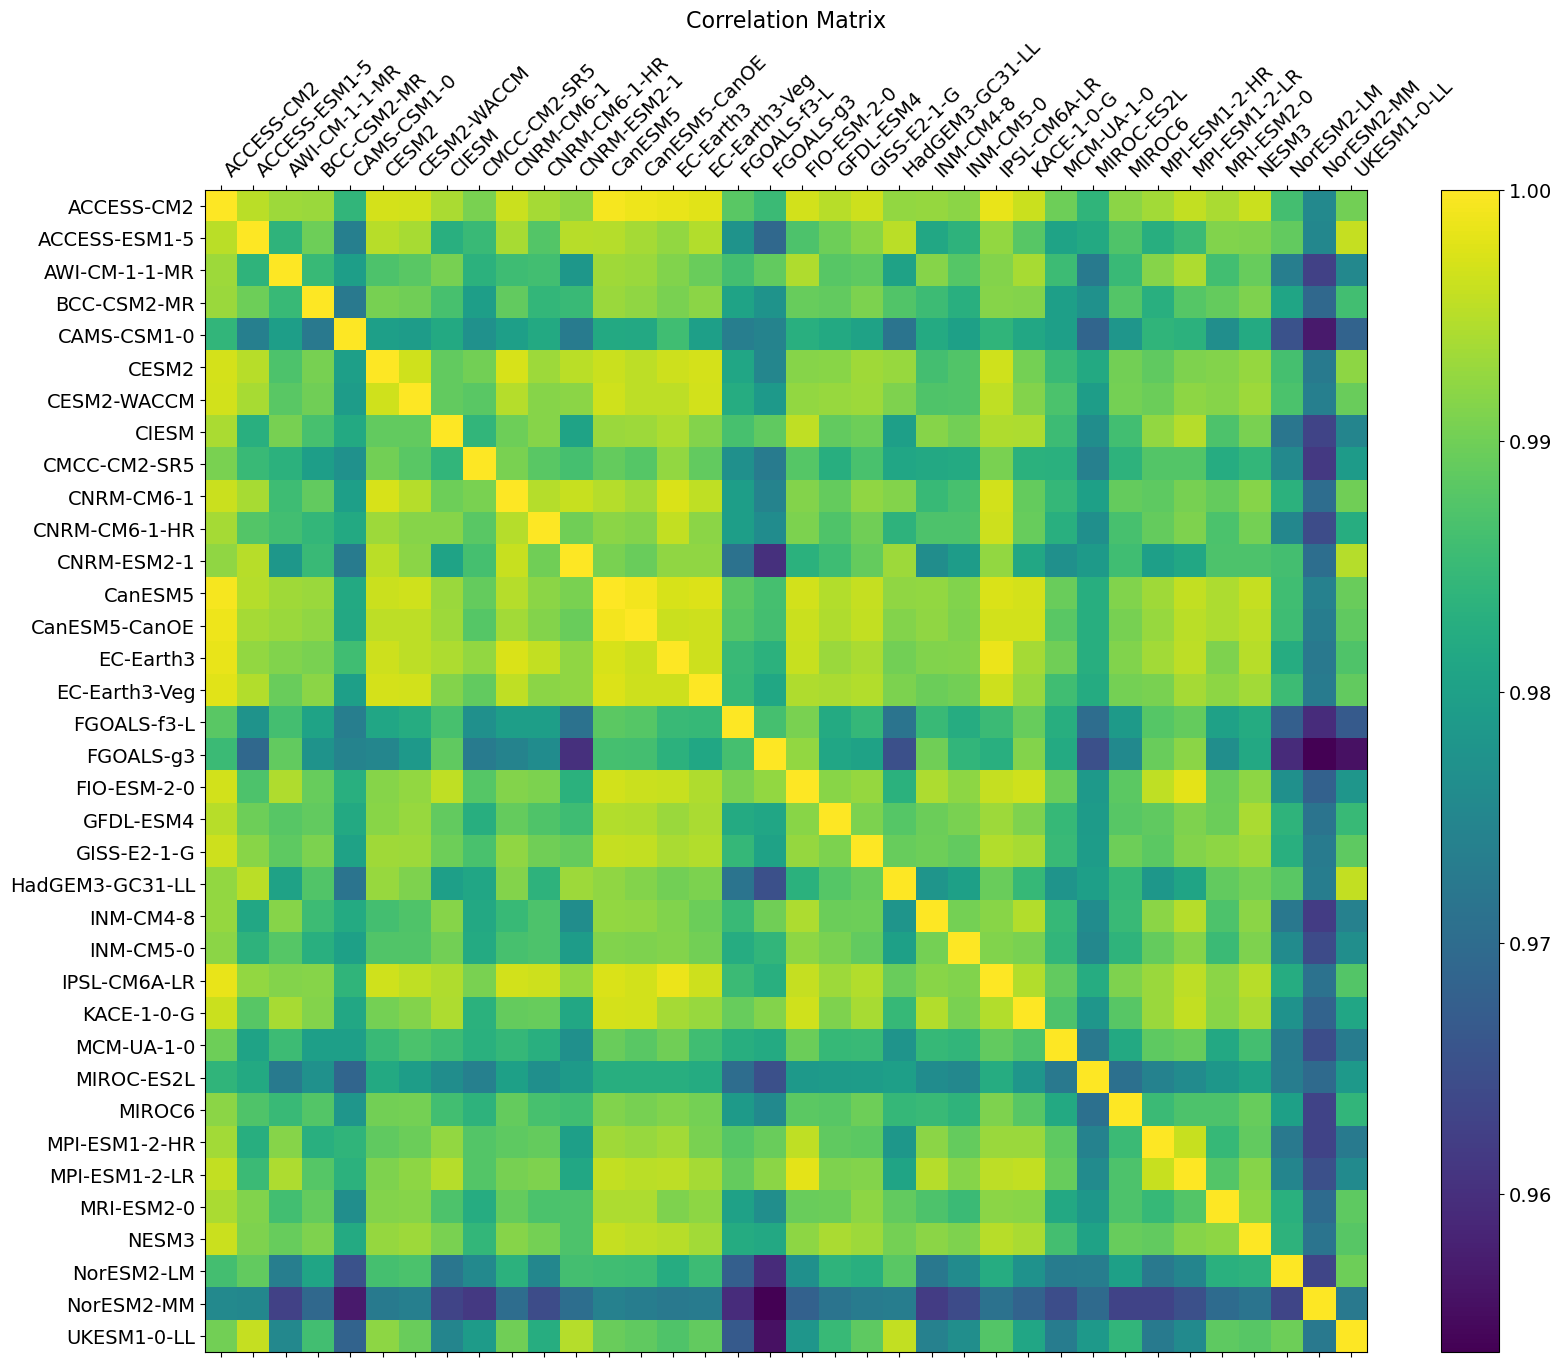

In [53]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Models Correlation Matrix', fontsize=16);

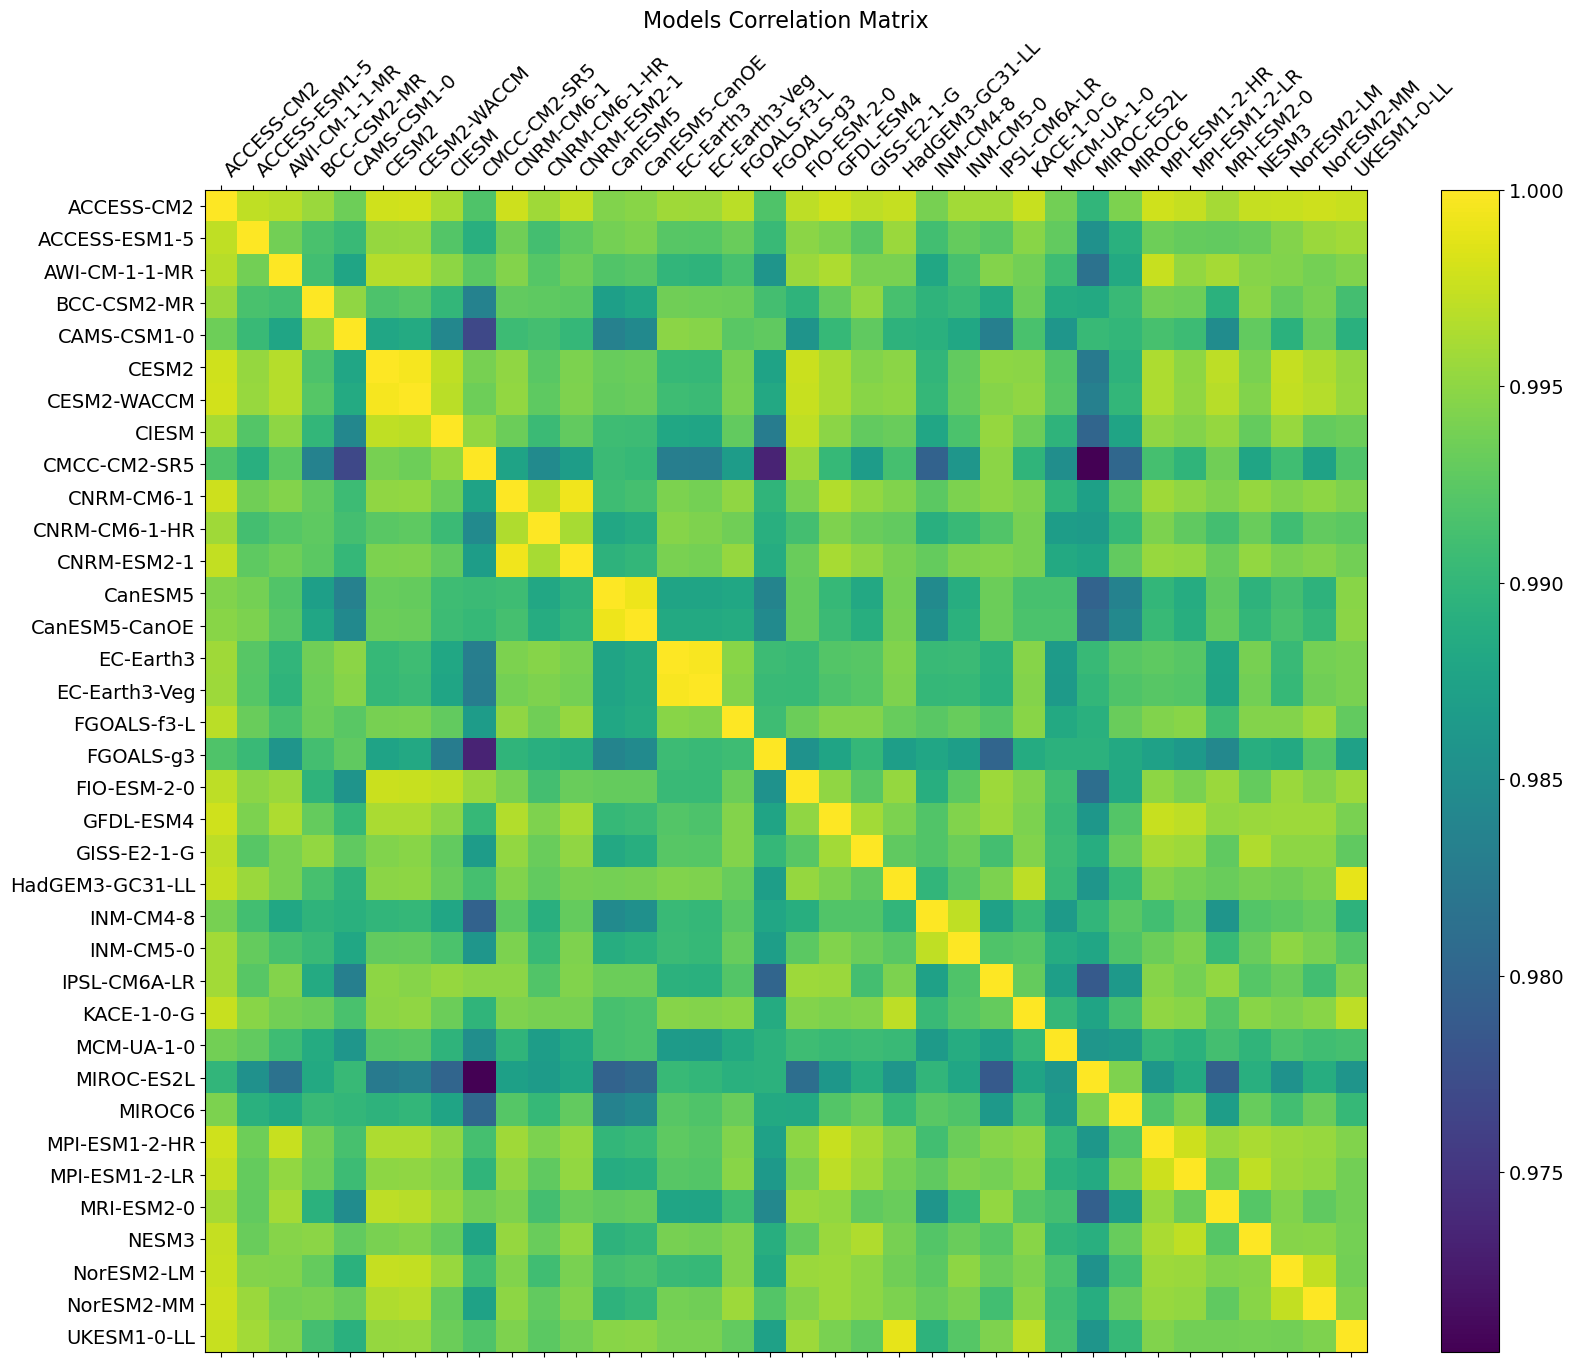

In [15]:
corr = corr_df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Models Correlation Matrix', fontsize=16);

In [1]:
file = open("model_names.txt", "r") 
data = file.read() 
data_into_list = data.split("\n")
file.close() 
names = data_into_list
names.pop(0)
names

['ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CanESM5 p1',
 'CanESM5 p2',
 'CanESM5-CanOE p2',
 'CESM2',
 'CESM2-WACCM',
 'CIESM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1 f2',
 'CNRM-CM6-1-HR f2',
 'CNRM-ESM2-1 f2',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G p1',
 'GISS-E2-1-G p3',
 'HadGEM3-GC31-LL f3',
 'HadGEM3-GC31-MM f3',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MCM-UA-1-0',
 'MIROC6',
 'MIROC-ES2L f2',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL f2']

In [5]:
model3_adj = pd.read_csv('model_final_edgeweights3.csv')
model3_adj.columns = names
model3_adj.index = names
model3_adj


,ACCESS-ESM1-5,AWI-CM-1-1-MR,BCC-CSM2-MR,CAMS-CSM1-0,CanESM5 p1,CanESM5 p2,CanESM5-CanOE p2,CESM2,CESM2-WACCM,CIESM,...,MCM-UA-1-0,MIROC6,MIROC-ES2L f2,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,UKESM1-0-LL f2
ACCESS-ESM1-5,0.000000e+00,1.478693e+00,1.477266e+00,1.477242e+00,1.477163e+00,1.477234e+00,1.471419e+00,1.477350e+00,1.478854e+00,1.478767e+00,...,1.477208e+00,1.471027e+00,1.477141e+00,1.471082e+00,1.477292e+00,1.471189e+00,1.471116e+00,1.477171e+00,1.478804e+00,1.477119e+00
AWI-CM-1-1-MR,1.439815e+00,0.000000e+00,1.411697e+00,1.418719e+00,1.418361e+00,1.418139e+00,1.418186e+00,1.404051e+00,1.418283e+00,1.411603e+00,...,1.418756e+00,1.418237e+00,1.403306e+00,1.418171e+00,1.403562e+00,1.418571e+00,1.404115e+00,1.403411e+00,1.418560e+00,1.411440e+00
BCC-CSM2-MR,1.448353e+00,1.448180e+00,0.000000e+00,1.418236e+00,2.068462e-27,2.714856e-27,4.621183e-27,3.149767e-27,3.236002e-27,1.015684e-27,...,3.906523e-26,6.186291e-27,1.316449e-26,3.276526e-27,2.566317e-27,4.158887e-27,3.037133e-27,6.794957e-27,8.719326e-27,1.033227e-27
CAMS-CSM1-0,1.439544e+00,1.445901e+00,1.448406e+00,0.000000e+00,4.717894e-27,6.109972e-26,3.294997e-27,2.214859e-17,2.323586e-17,2.776080e-17,...,2.434725e-17,1.948399e-17,2.281380e-17,5.502694e-17,3.288031e-17,2.440728e-17,2.251864e-17,2.151793e-17,2.446522e-17,2.261724e-17
CanESM5 p1,1.448299e+00,1.440274e+00,1.448571e+00,1.448199e+00,0.000000e+00,1.970033e-17,3.347862e-17,2.188176e-17,2.438634e-17,7.823945e-17,...,1.702212e-14,1.333388e-14,1.207510e-14,1.163277e-14,1.169628e-14,1.399658e-14,1.273998e-14,2.230130e-14,1.683197e-14,1.275039e-14
CanESM5 p2,1.439350e+00,1.448230e+00,1.439464e+00,1.448369e+00,1.439812e+00,0.000000e+00,1.457595e-14,1.525936e-14,1.291211e-14,1.855589e-14,...,2.258683e-25,4.796412e-25,2.520390e-25,2.274063e-25,2.363329e-25,3.645072e-25,1.652661e-25,1.492199e-25,1.316365e-25,1.030700e-25
CanESM5-CanOE p2,1.439497e+00,1.448488e+00,1.446264e+00,1.448284e+00,3.606579e-01,3.605407e-01,0.000000e+00,1.915555e-25,1.696213e-25,1.076556e-24,...,2.102478e-01,2.096126e-01,2.095511e-01,2.092156e-01,1.595614e-01,1.579665e-01,2.106401e-01,2.092415e-01,2.204705e-01,2.228691e-01
CESM2,3.638309e-01,3.636510e-01,3.634472e-01,3.634115e-01,3.445983e-01,3.636151e-01,3.605030e-01,0.000000e+00,2.237358e-01,2.101038e-01,...,-4.523771e-34,3.072306e-36,-2.521509e-36,2.302532e-36,-1.970678e-34,7.104628e-37,-6.188319e-39,-5.535462e-33,3.243289e-36,-4.221982e-36
CESM2-WACCM,3.607971e-01,3.607362e-01,3.604509e-01,3.455976e-01,3.456207e-01,3.605690e-01,3.606862e-01,3.634366e-01,0.000000e+00,-8.929972e-35,...,-2.010922e-39,3.083774e-36,-4.347551e-33,6.339680e-38,-6.514785e-35,-2.252800e-33,-2.335481e-35,-9.343720e-36,1.198252e+00,1.129621e+00
CIESM,3.632883e-01,3.636187e-01,3.603863e-01,3.632519e-01,3.633033e-01,3.455288e-01,3.602965e-01,3.634656e-01,3.636715e-01,0.000000e+00,...,1.418997e+00,6.651475e-01,1.134617e+00,1.419942e+00,1.420589e+00,8.090394e-01,1.421633e+00,1.419318e+00,6.918698e-01,1.418181e+00


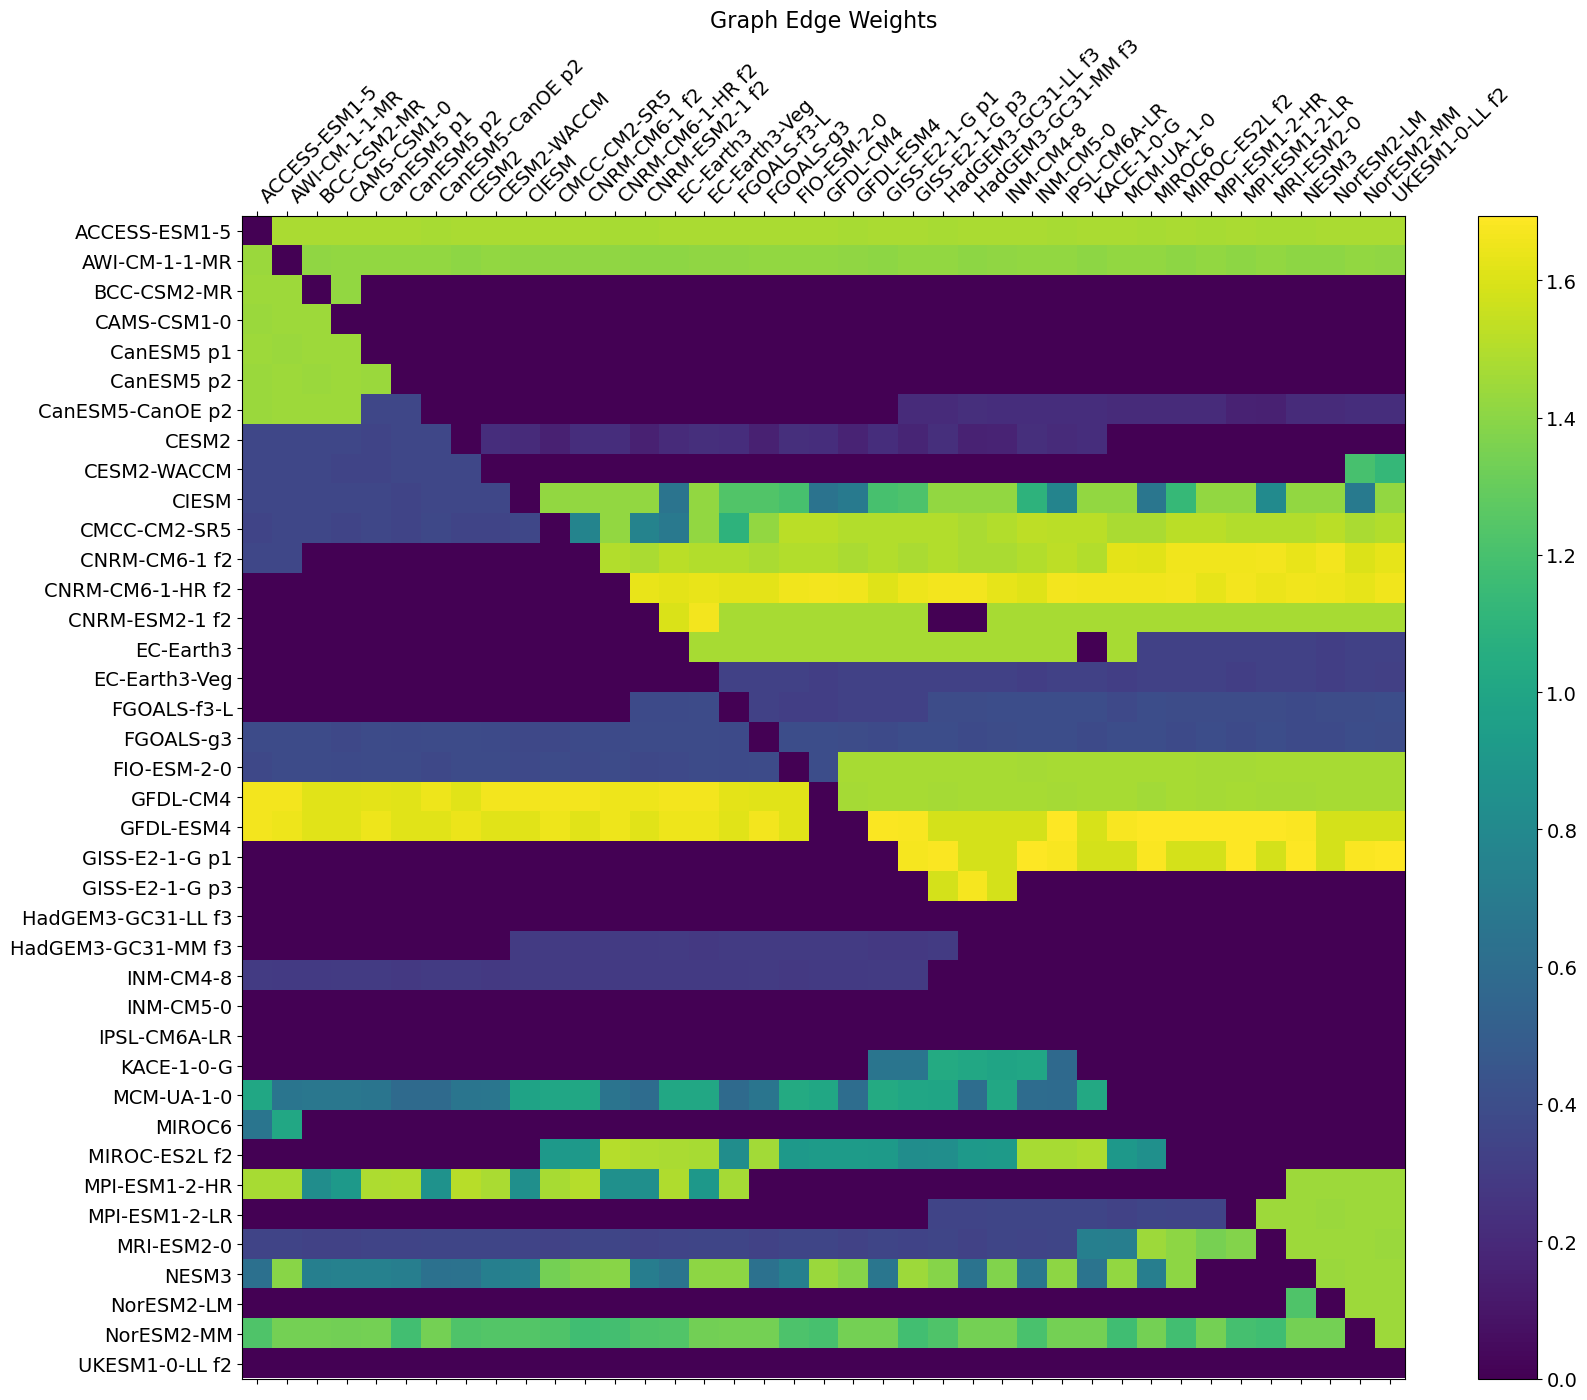

In [7]:
f = plt.figure(figsize=(19, 15))
plt.matshow(model3_adj, fignum=f.number)
plt.xticks(range(model3_adj.select_dtypes(['number']).shape[1]), model3_adj.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(model3_adj.select_dtypes(['number']).shape[1]), model3_adj.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Graph Edge Weights', fontsize=16);

In [8]:
modelfinal_adj = pd.read_csv('model_final_edgeweights.csv')
modelfinal_adj.columns = names
modelfinal_adj.index = names
modelfinal_adj

,ACCESS-ESM1-5,AWI-CM-1-1-MR,BCC-CSM2-MR,CAMS-CSM1-0,CanESM5 p1,CanESM5 p2,CanESM5-CanOE p2,CESM2,CESM2-WACCM,CIESM,...,MCM-UA-1-0,MIROC6,MIROC-ES2L f2,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,UKESM1-0-LL f2
ACCESS-ESM1-5,0.000000e+00,3.380936e-01,3.379887e-01,3.389341e-01,3.380899e-01,3.381739e-01,3.379431e-01,3.381668e-01,3.380589e-01,3.380114e-01,...,3.389804e-01,3.379148e-01,3.378848e-01,3.380631e-01,3.381649e-01,3.389567e-01,3.388908e-01,3.389931e-01,3.381746e-01,3.380238e-01
AWI-CM-1-1-MR,1.455787e+00,0.000000e+00,3.264789e-17,-2.276906e-17,-8.266973e-17,1.397577e-17,1.519550e-16,-7.741029e-17,-5.852152e-17,-2.564688e-16,...,-1.584123e-16,1.519494e-18,1.138338e-16,-5.539764e-17,-1.638700e-17,-4.994560e-17,-1.568154e-16,-1.660729e-16,-1.307816e-16,-9.889061e-17
BCC-CSM2-MR,1.455787e+00,1.455786e+00,0.000000e+00,1.081637e-16,-5.981408e-17,-1.112303e-16,-1.078852e-17,-9.367875e-17,1.010828e-16,-1.146344e-16,...,9.173442e-17,-6.492372e-17,-2.723410e-17,-9.754714e-17,7.342679e-17,1.116742e-16,-1.038702e-16,2.464274e-17,-1.117505e-16,1.003868e-16
CAMS-CSM1-0,1.455797e+00,1.455787e+00,1.455797e+00,0.000000e+00,-1.094153e-16,-1.431787e-18,-3.594433e-17,1.455652e+00,1.455694e+00,1.455698e+00,...,1.455695e+00,1.455652e+00,1.455697e+00,1.455698e+00,1.455699e+00,1.455658e+00,1.455654e+00,1.455654e+00,1.455652e+00,1.455696e+00
CanESM5 p1,1.455797e+00,1.455798e+00,1.455788e+00,1.455787e+00,0.000000e+00,1.455697e+00,1.455655e+00,1.455656e+00,1.455654e+00,1.455695e+00,...,-1.081697e-16,8.487760e-17,-3.389900e-17,-1.039835e-16,-5.452874e-19,-1.056759e-16,4.571619e-17,-3.635393e-18,4.355314e-17,1.019608e-16
CanESM5 p2,1.455787e+00,1.455787e+00,1.455796e+00,1.455796e+00,1.455787e+00,0.000000e+00,-8.883402e-17,-4.248173e-17,-1.100898e-16,2.120933e-17,...,-6.191731e-16,-4.854735e-17,-3.657205e-16,8.739392e-17,-6.127719e-16,1.739673e-16,-5.155946e-16,3.253660e-16,1.149268e-17,-1.700703e-16
CanESM5-CanOE p2,1.455786e+00,1.455786e+00,1.455797e+00,1.455797e+00,3.489460e-01,3.501279e-01,0.000000e+00,1.953269e-16,-4.541707e-16,-1.084324e-15,...,3.383787e-01,3.383615e-01,3.382569e-01,3.384507e-01,3.391536e-01,3.380173e-01,3.382829e-01,3.383028e-01,3.381111e-01,3.384516e-01
CESM2,3.502276e-01,3.495984e-01,3.502090e-01,3.501786e-01,3.489641e-01,3.501007e-01,3.501691e-01,0.000000e+00,3.380382e-01,3.392220e-01,...,4.746729e-17,7.934005e-17,8.515143e-17,-4.341651e-17,-3.603314e-17,-7.385548e-17,2.205330e-17,-8.145809e-17,-6.405159e-17,8.299182e-17
CESM2-WACCM,3.502460e-01,3.501448e-01,3.501879e-01,3.495324e-01,3.489222e-01,3.501304e-01,3.501818e-01,3.489332e-01,0.000000e+00,-6.436151e-17,...,-5.556559e-17,8.002156e-17,-3.439884e-17,8.730762e-17,-6.678595e-17,3.753920e-17,-7.485077e-17,-7.164270e-17,-1.260545e-16,-1.310180e-16
CIESM,3.502010e-01,3.489465e-01,3.496193e-01,3.496123e-01,3.489270e-01,3.500915e-01,3.488952e-01,3.502184e-01,3.501343e-01,0.000000e+00,...,-1.335568e-16,1.272296e-16,-6.756040e-17,-8.143565e-17,1.223758e-16,-1.148016e-16,-2.181992e-17,-1.312996e-16,-1.349140e-16,-1.305739e-16


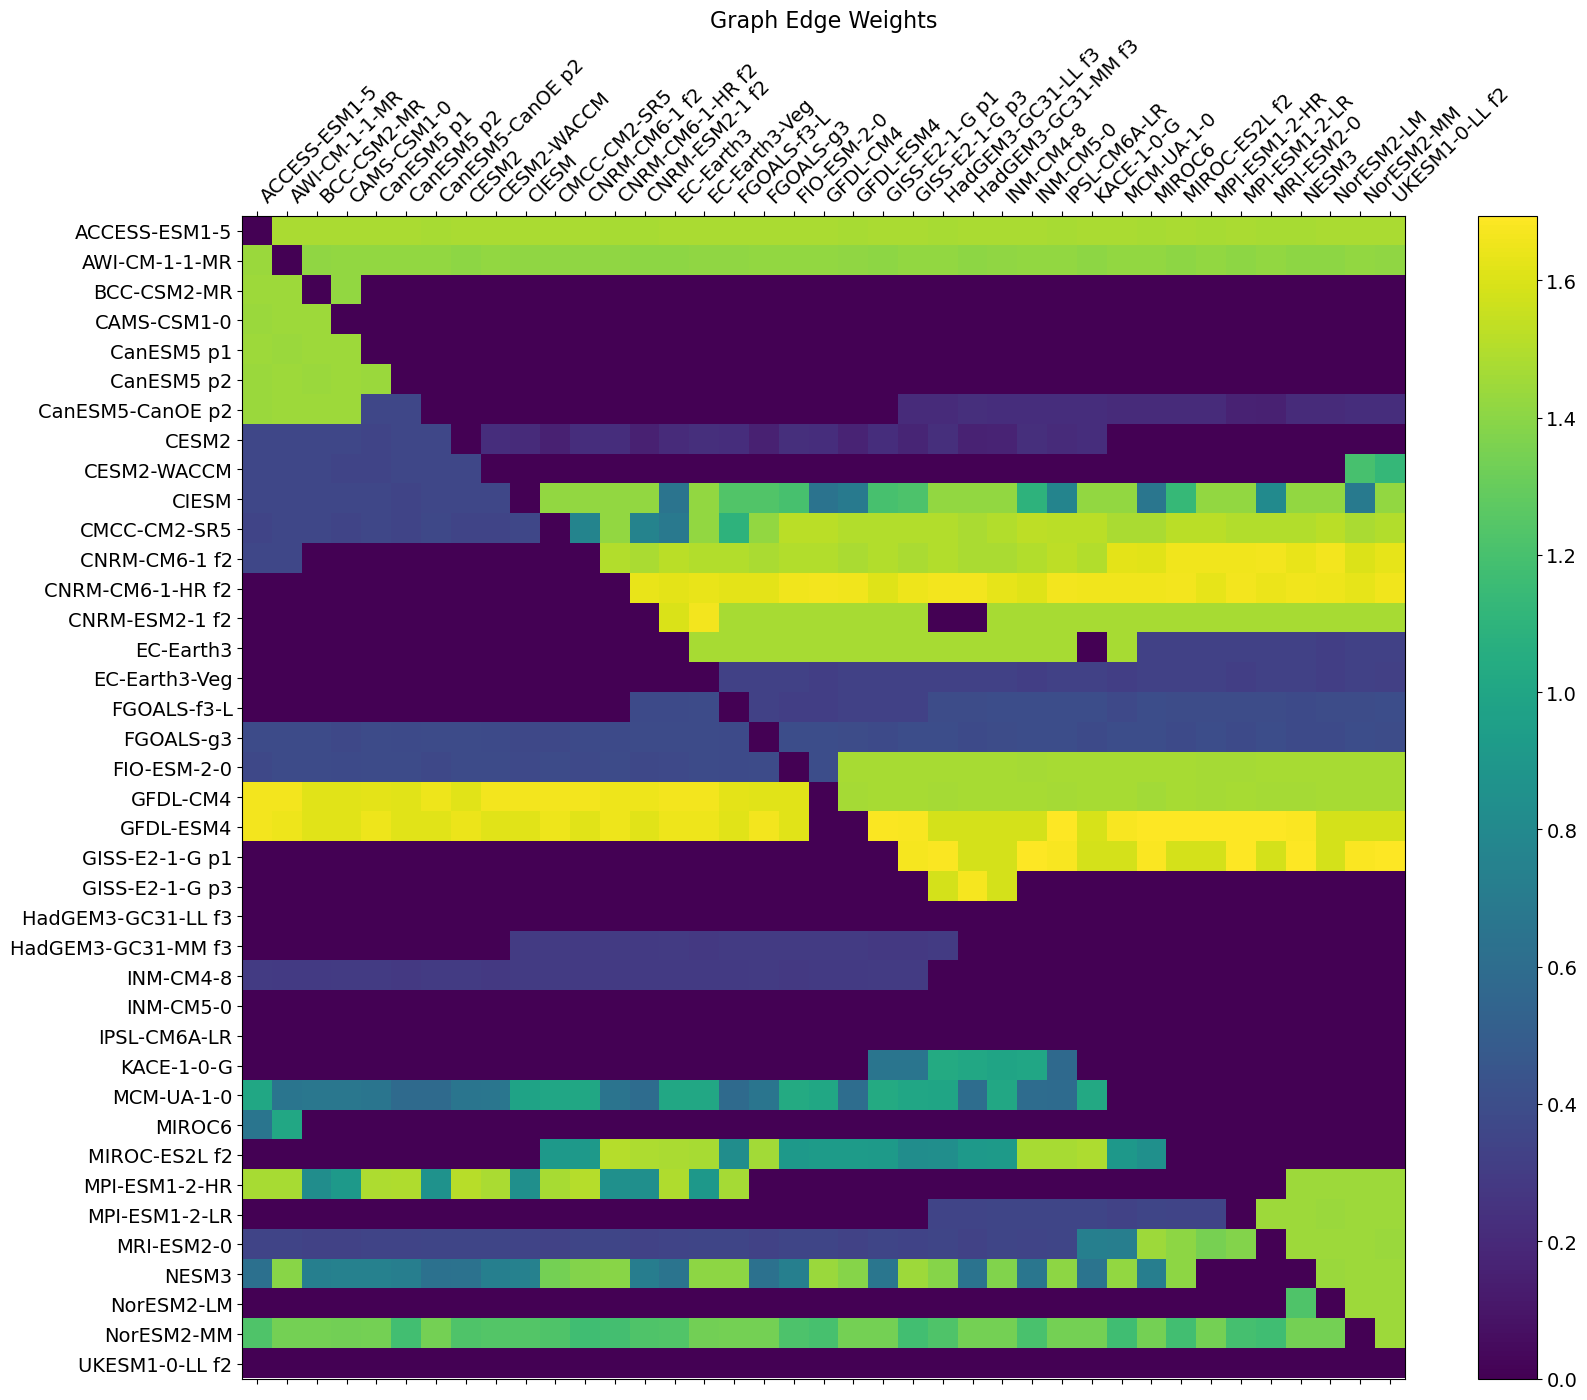

In [9]:
f = plt.figure(figsize=(19, 15))
plt.matshow(model3_adj, fignum=f.number)
plt.xticks(range(model3_adj.select_dtypes(['number']).shape[1]), model3_adj.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(model3_adj.select_dtypes(['number']).shape[1]), model3_adj.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Graph Edge Weights alpha=0.5', fontsize=16);


In [10]:
import networkx as nx

In [16]:
G = nx.from_pandas_adjacency(model3_adj)
# pos = nx.spring_layout(G, seed=7)
# nx.draw_networkx(G)
print(G)

Graph with 39 nodes and 741 edges


In [21]:
model4_adj = pd.read_csv('model4_edges.csv')
model4_adj
model4_adj.columns = names
model4_adj.index = names
model4_adj

,ACCESS-ESM1-5,AWI-CM-1-1-MR,BCC-CSM2-MR,CAMS-CSM1-0,CanESM5 p1,CanESM5 p2,CanESM5-CanOE p2,CESM2,CESM2-WACCM,CIESM,...,MCM-UA-1-0,MIROC6,MIROC-ES2L f2,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,UKESM1-0-LL f2
ACCESS-ESM1-5,0.000000e+00,4.693160e-20,4.916868e-20,3.377754e-20,4.087740e-20,5.123811e-20,3.898584e-20,5.118534e-20,5.913554e-20,4.705760e-20,...,4.330767e-20,4.604436e-20,3.193138e-20,4.612987e-20,4.153065e-20,5.469595e-20,4.900472e-20,4.443534e-20,5.729821e-20,3.949525e-20
AWI-CM-1-1-MR,1.257000e-41,0.000000e+00,3.340636e-01,3.125454e-01,3.339574e-01,3.162669e-01,3.218183e-01,3.346920e-01,3.151950e-01,3.278101e-01,...,3.139418e-01,3.118697e-01,3.221541e-01,3.336025e-01,3.340319e-01,3.208720e-01,3.183329e-01,3.109884e-01,3.344122e-01,3.178963e-01
BCC-CSM2-MR,1.184000e-41,1.227800e-41,0.000000e+00,3.337632e-01,2.874149e-01,2.662598e-01,2.873102e-01,2.712257e-01,2.725632e-01,2.852663e-01,...,2.864628e-01,2.867973e-01,2.676867e-01,2.659136e-01,2.733637e-01,2.869065e-01,2.870560e-01,2.709555e-01,2.737213e-01,2.651090e-01
CAMS-CSM1-0,1.244100e-41,1.255000e-41,1.165000e-41,0.000000e+00,2.863613e-01,2.734711e-01,2.855313e-01,1.060725e-31,7.648547e-32,1.067039e-31,...,3.358641e-32,6.749293e-32,2.969644e-31,9.785138e-32,2.438618e-31,2.819718e-31,8.928635e-32,1.162326e-31,3.378469e-32,2.105368e-31
CanESM5 p1,1.215900e-41,1.237500e-41,1.226800e-41,1.191500e-41,0.000000e+00,3.226154e-31,3.409347e-31,9.512196e-32,1.292851e-31,2.306465e-31,...,9.806999e-01,6.980123e-02,9.884267e-01,1.004395e+00,7.318274e-03,9.830414e-01,1.009324e+00,9.938866e-01,1.005311e+00,6.939919e-02
CanESM5 p2,1.164200e-41,1.177200e-41,1.170000e-41,1.165500e-41,1.216700e-41,0.000000e+00,6.070697e-02,8.397570e-01,9.848815e-01,9.918758e-01,...,8.944413e-01,1.067722e+00,8.961474e-01,1.014813e+00,1.065488e+00,1.055407e+00,8.965912e-01,1.059045e+00,1.064671e+00,8.997010e-01
CanESM5-CanOE p2,1.252900e-41,1.238900e-41,1.194700e-41,1.239600e-41,1.501867e-01,1.314993e-01,0.000000e+00,1.056740e+00,1.066567e+00,1.060282e+00,...,6.763892e-23,6.806797e-23,8.845006e-23,5.183300e-23,3.655371e-23,6.767298e-23,6.335349e-23,7.195154e-23,6.248074e-23,5.539438e-23
CESM2,1.337595e-01,1.499728e-01,1.497321e-01,1.378770e-01,1.491868e-01,1.465448e-01,1.492513e-01,0.000000e+00,5.977077e-23,5.152416e-23,...,1.081030e+00,3.631797e-01,3.495484e-01,1.079677e+00,3.782738e-01,9.355789e-01,1.086141e+00,8.978779e-01,1.096602e+00,3.983455e-01
CESM2-WACCM,1.529918e-01,1.577008e-01,1.495144e-01,1.502330e-01,1.327963e-01,1.311607e-01,1.513417e-01,1.350793e-01,0.000000e+00,1.082919e+00,...,1.073734e+00,1.079667e+00,9.594767e-01,3.645674e-01,3.041377e-01,1.080782e+00,3.711001e-01,1.069948e+00,1.708000e-42,1.382770e+00
CIESM,1.416815e-01,1.502487e-01,1.473840e-01,1.485565e-01,1.512702e-01,1.598701e-01,1.474572e-01,1.513224e-01,1.499712e-01,0.000000e+00,...,1.398311e+00,8.342000e-42,7.515000e-42,1.398993e+00,-3.966000e-42,-1.234100e-41,-6.120000e-42,-1.122000e-41,-1.036400e-41,5.653000e-42


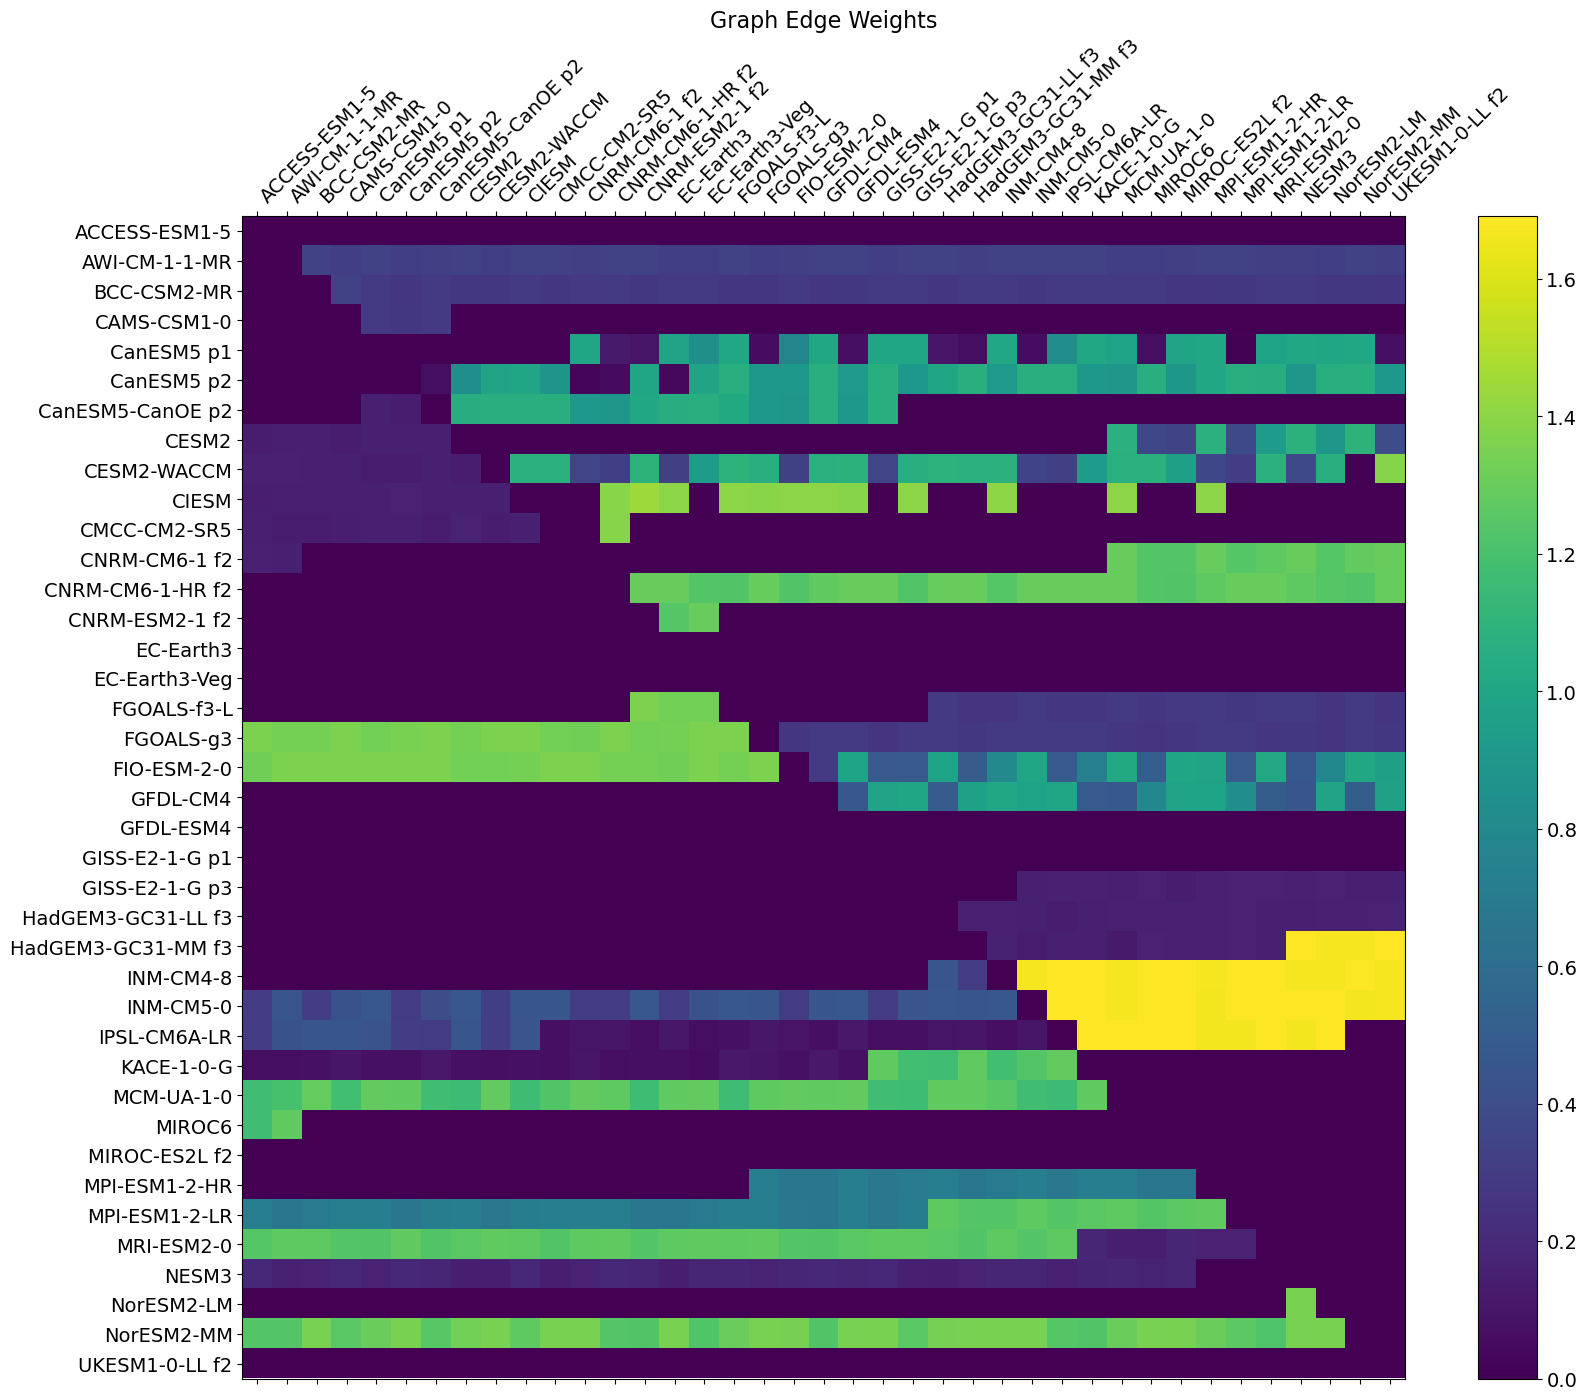

In [22]:
f = plt.figure(figsize=(19, 15))
plt.matshow(model4_adj, fignum=f.number)
plt.xticks(range(model4_adj.select_dtypes(['number']).shape[1]), model4_adj.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(model4_adj.select_dtypes(['number']).shape[1]), model4_adj.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Graph Edge Weights', fontsize=16);

In [26]:
import networkx as nx
A = model4_adj.to_numpy()

# Create DiGraph from A
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)

# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G)

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, with_labels=True)

# Get weights of each edge and assign to labels
labels = nx.get_edge_attributes(G, "weight")

# Draw edge labels using layout and list of labels
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

# Show plot
plt.show()



TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [31]:
def plot_adj(filename, title=''):
    df = pd.read_csv(filename)
    df.columns = names
    df.index = names
    
    f = plt.figure(figsize=(19, 15))
    plt.matshow(df, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=16);

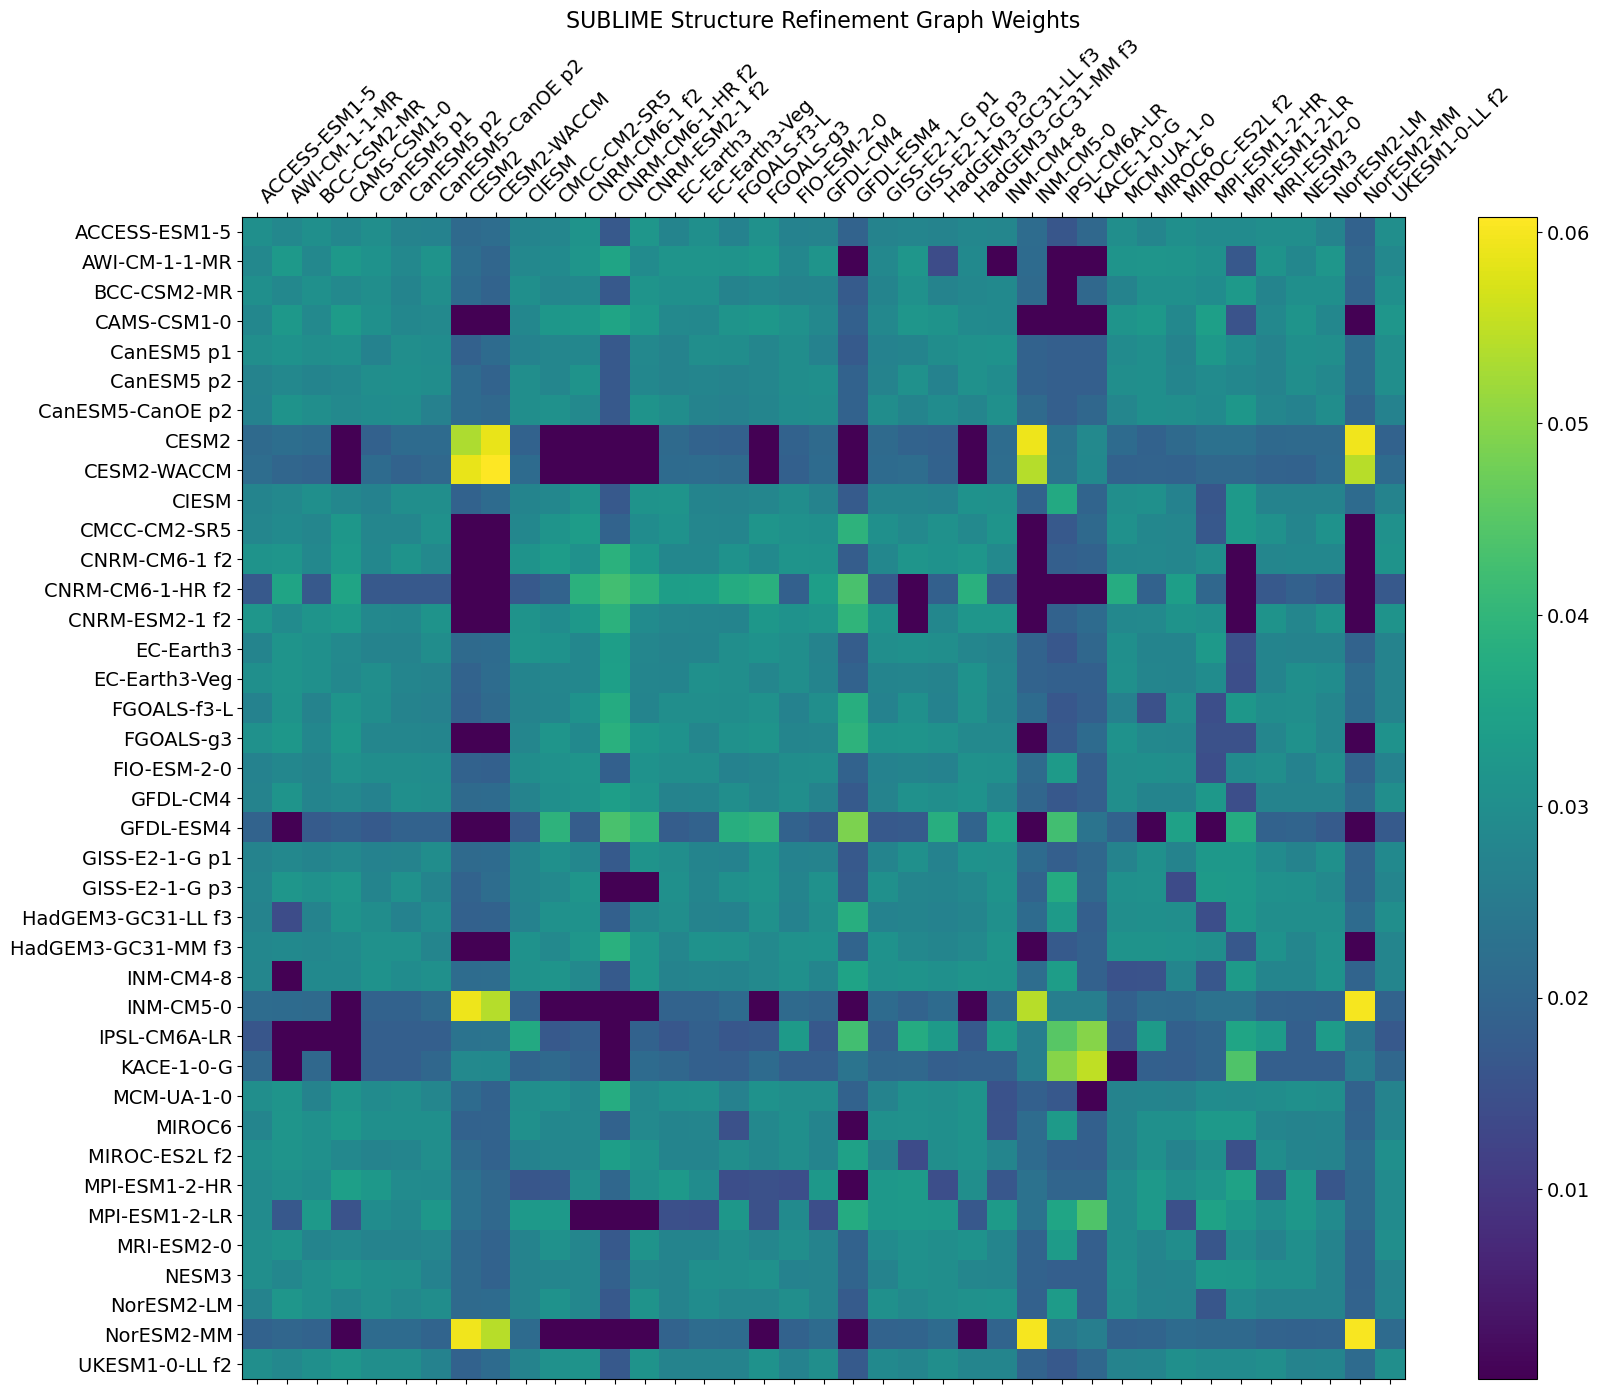

In [37]:
plot_adj('sublime_adj.csv', 'SUBLIME Structure Refinement Graph Weights')

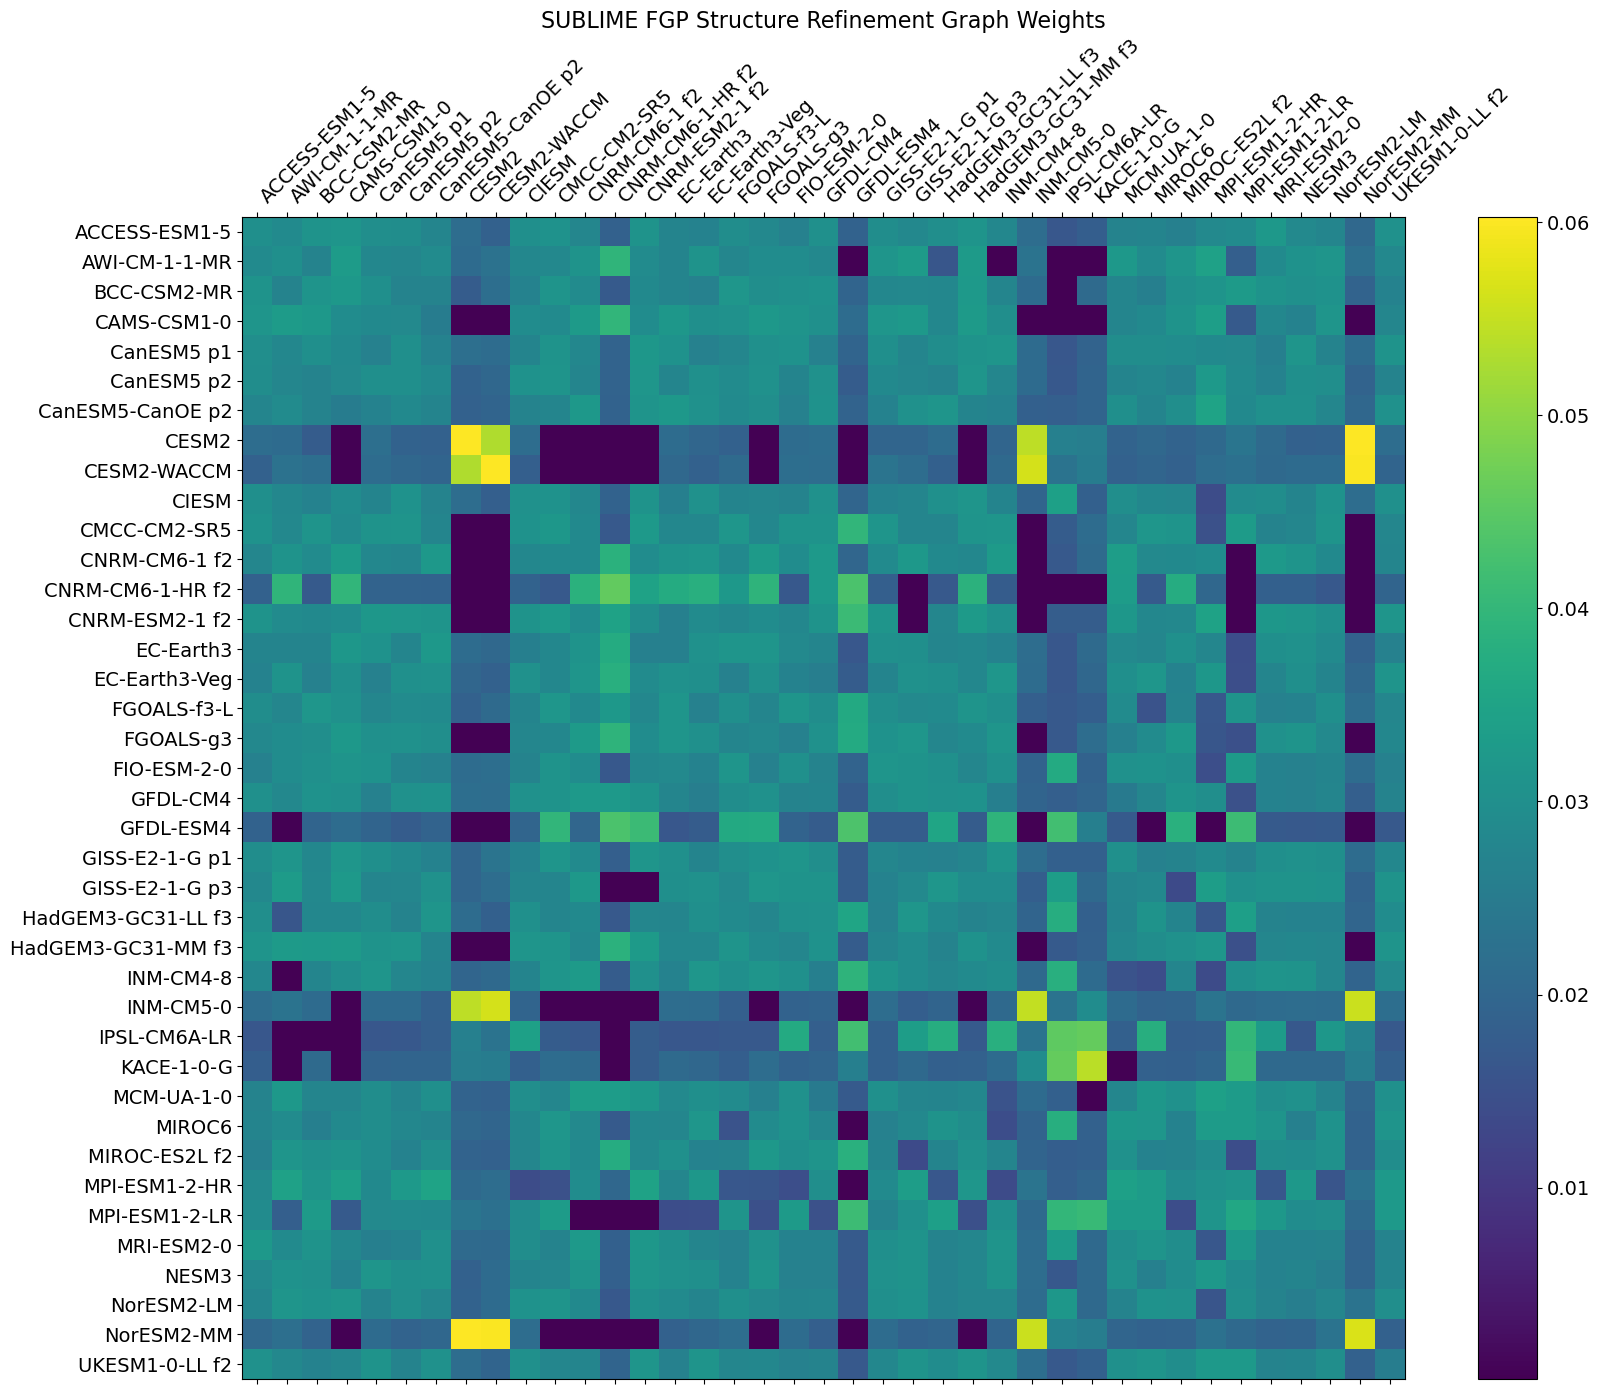

In [34]:
plot_adj('sublime_fgp_sr_adj.csv', 'SUBLIME FGP Structure Refinement Graph Weights')